## We have to python libarary implement and scartch


implement backpropagation for MLP and apply it to MNIST with one hidden layer.
implement MLP with pytorch (or tensorflow) and apply it to MNIST
 

In [ ]:
# google drive. so we have to monunt
from google.colab import drive # /content/drive/MyDrive/project/MachineLearning/dataset/mnist.pkl
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data. I load 
import six.moves.cPickle as pickle
import gzip
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns
import math
import pickle
import pandas as pd

In [ ]:
def load_data(dataset): # data load : HDLMS source code utilize
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split('/content/drive/MyDrive/project/MachineLearning/dataset/')[0],
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.

    return train_set, valid_set, test_set

In [ ]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [ ]:
print(val_x.shape)
print(val_y.shape)

(10000, 784)
(10000,)


In [ ]:
import numpy as np
from urllib import request
import gzip
import pickle

In [ ]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [ ]:
eta=0.001
alpha=0.001
n_iter= 50 # epoch
batch_size= 50 # batch size 50

In [ ]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
    
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
    
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())
            
        train_losses.sort()        
        plt.plot(train_losses, "deeppink")
        plt.title("MLP epoch 50 , loss")
        plt.show()

n_iter: 50
epoch  0 training accuracy 0.45
epoch  1 training accuracy 0.56
epoch  2 training accuracy 0.61
epoch  3 training accuracy 0.65
epoch  4 training accuracy 0.68
epoch  5 training accuracy 0.70
epoch  6 training accuracy 0.72
epoch  7 training accuracy 0.73
epoch  8 training accuracy 0.75
epoch  9 training accuracy 0.76
epoch  10 training accuracy 0.77
epoch  11 training accuracy 0.78
epoch  12 training accuracy 0.78
epoch  13 training accuracy 0.79
epoch  14 training accuracy 0.80
epoch  15 training accuracy 0.80
epoch  16 training accuracy 0.81
epoch  17 training accuracy 0.81
epoch  18 training accuracy 0.82
epoch  19 training accuracy 0.82
epoch  20 training accuracy 0.82
epoch  21 training accuracy 0.83
epoch  22 training accuracy 0.83
epoch  23 training accuracy 0.83
epoch  24 training accuracy 0.84
epoch  25 training accuracy 0.84
epoch  26 training accuracy 0.84
epoch  27 training accuracy 0.84
epoch  28 training accuracy 0.85
epoch  29 training accuracy 0.85
epoch  30

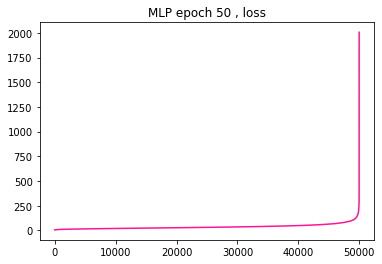

In [ ]:
if __name__ == '__main__':
  print("n_iter: 50")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

In [ ]:
eta=0.01
alpha=0.001
n_iter= 50 # epoch
batch_size= 50 #

In [ ]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [ ]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
        train_losses.sort()
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                #train_losses.append(loss)
                
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
                train_losses.append(loss/len(X))
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())


        train_losses.sort()        
        plt.plot(train_losses, "deepskyblue")
        plt.title("MLP epoch 50, batch size 50 | loss")
        plt.show()

n_iter: 50 / learning rate 0.01
epoch  0 training accuracy 0.74
epoch  1 training accuracy 0.81
epoch  2 training accuracy 0.84
epoch  3 training accuracy 0.86
epoch  4 training accuracy 0.87
epoch  5 training accuracy 0.88
epoch  6 training accuracy 0.89
epoch  7 training accuracy 0.90
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.91
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.92
epoch  12 training accuracy 0.92
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.93
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.94
epoch  20 training accuracy 0.94
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.95
epoch  26 training accuracy 0.95
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch  29 training ac

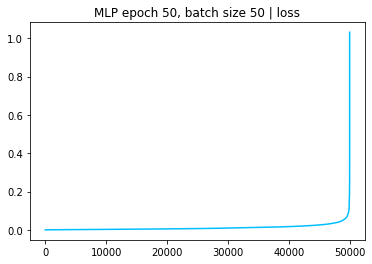

In [ ]:
if __name__ == '__main__':
  print("n_iter: 50 / learning rate 0.01")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y) # learning rate 0.01 # batch size 50 # epoch 50  # error / len(X) zip(X, y) the 

In [ ]:
eta=0.01
alpha=0.001
n_iter= 100 # epoch
batch_size= 50

In [ ]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [ ]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
    
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                #train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
                train_losses.append(loss/len(X))
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())
            
        train_losses.sort()        
        plt.plot(train_losses, "aqua")
        plt.title("MLP epoch 100 batch size 50, loss")
        plt.show()

n_iter: 100 / learning rate 0.01
epoch  0 training accuracy 0.73
epoch  1 training accuracy 0.80
epoch  2 training accuracy 0.83
epoch  3 training accuracy 0.85
epoch  4 training accuracy 0.86
epoch  5 training accuracy 0.87
epoch  6 training accuracy 0.88
epoch  7 training accuracy 0.89
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.90
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.91
epoch  12 training accuracy 0.91
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.92
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.93
epoch  20 training accuracy 0.93
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.94
epoch  26 training accuracy 0.94
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch  29 training a

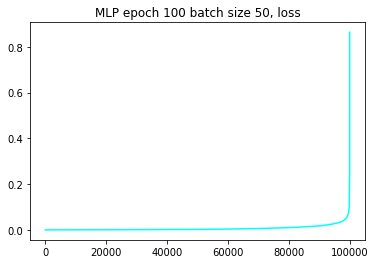

In [ ]:
if __name__ == '__main__':
  print("n_iter: 100 / learning rate 0.01")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y) # learning rate 0.01

In [ ]:
eta=0.01
alpha=0.001
n_iter= 200 # epoch
batch_size= 50

In [ ]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [ ]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
    
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                #train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
                train_losses.append(loss/len(X))
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())
            
        train_losses.sort()        
        plt.plot(train_losses, "coral")
        plt.title("MLP epoch 200 batch size 50, loss")
        plt.show()

n_iter: 200 / learning rate 0.01
epoch  0 training accuracy 0.74
epoch  1 training accuracy 0.80
epoch  2 training accuracy 0.83
epoch  3 training accuracy 0.85
epoch  4 training accuracy 0.87
epoch  5 training accuracy 0.88
epoch  6 training accuracy 0.89
epoch  7 training accuracy 0.89
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.90
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.91
epoch  12 training accuracy 0.92
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.93
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.93
epoch  20 training accuracy 0.94
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.94
epoch  26 training accuracy 0.95
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch  29 training a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


epoch  175 training accuracy 0.99
epoch  176 training accuracy 0.99
epoch  177 training accuracy 0.99
epoch  178 training accuracy 0.99
epoch  179 training accuracy 0.99
epoch  180 training accuracy 0.99
epoch  181 training accuracy 0.99
epoch  182 training accuracy 0.99
epoch  183 training accuracy 0.99
epoch  184 training accuracy 0.99
epoch  185 training accuracy 0.99
epoch  186 training accuracy 0.99
epoch  187 training accuracy 0.99
epoch  188 training accuracy 0.99
epoch  189 training accuracy 0.99
epoch  190 training accuracy 0.99
epoch  191 training accuracy 0.99
epoch  192 training accuracy 0.99
epoch  193 training accuracy 0.99
epoch  194 training accuracy 0.99
epoch  195 training accuracy 0.99
epoch  196 training accuracy 0.99
epoch  197 training accuracy 0.99
epoch  198 training accuracy 0.99
epoch  199 training accuracy 0.99


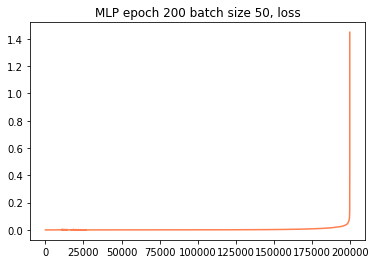

In [ ]:
if __name__ == '__main__':
  print("n_iter: 200 / learning rate 0.01")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

In [ ]:
eta=0.01
alpha=0.001
n_iter= 500 # epoch
batch_size= 50

In [ ]:
if __name__ == '__main__':
  print("n_iter: 50")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

n_iter: 50
epoch  0 training accuracy 0.42
epoch  1 training accuracy 0.53
epoch  2 training accuracy 0.59
epoch  3 training accuracy 0.63
epoch  4 training accuracy 0.66
epoch  5 training accuracy 0.69
epoch  6 training accuracy 0.71
epoch  7 training accuracy 0.72
epoch  8 training accuracy 0.73
epoch  9 training accuracy 0.75
epoch  10 training accuracy 0.76
epoch  11 training accuracy 0.76
epoch  12 training accuracy 0.77
epoch  13 training accuracy 0.78
epoch  14 training accuracy 0.79
epoch  15 training accuracy 0.79
epoch  16 training accuracy 0.80
epoch  17 training accuracy 0.80
epoch  18 training accuracy 0.81
epoch  19 training accuracy 0.81
epoch  20 training accuracy 0.81
epoch  21 training accuracy 0.82
epoch  22 training accuracy 0.82
epoch  23 training accuracy 0.82
epoch  24 training accuracy 0.83
epoch  25 training accuracy 0.83
epoch  26 training accuracy 0.83
epoch  27 training accuracy 0.84
epoch  28 training accuracy 0.84
epoch  29 training accuracy 0.84
epoch  30

In [ ]:
eta=0.001
alpha=0.001
n_iter=200
batch_size=50

In [ ]:
if __name__ == '__main__':
  print("n_iter: 200 (MLP)")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

n_iter: 200 (MLP)
epoch  0 training accuracy 0.48
epoch  1 training accuracy 0.59
epoch  2 training accuracy 0.64
epoch  3 training accuracy 0.68
epoch  4 training accuracy 0.70
epoch  5 training accuracy 0.72
epoch  6 training accuracy 0.74
epoch  7 training accuracy 0.75
epoch  8 training accuracy 0.77
epoch  9 training accuracy 0.77
epoch  10 training accuracy 0.78
epoch  11 training accuracy 0.79
epoch  12 training accuracy 0.80
epoch  13 training accuracy 0.80
epoch  14 training accuracy 0.81
epoch  15 training accuracy 0.81
epoch  16 training accuracy 0.82
epoch  17 training accuracy 0.82
epoch  18 training accuracy 0.83
epoch  19 training accuracy 0.83
epoch  20 training accuracy 0.83
epoch  21 training accuracy 0.84
epoch  22 training accuracy 0.84
epoch  23 training accuracy 0.84
epoch  24 training accuracy 0.84
epoch  25 training accuracy 0.85
epoch  26 training accuracy 0.85
epoch  27 training accuracy 0.85
epoch  28 training accuracy 0.85
epoch  29 training accuracy 0.86
ep

In [ ]:
eta=0.001
alpha=0.001
n_iter=200
batch_size=100

In [ ]:
if __name__ == '__main__':
  print("n_iter: 200 / batch size 100(MLP)")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

n_iter: 200 / batch size 100(MLP)
epoch  0 training accuracy 0.47
epoch  1 training accuracy 0.57
epoch  2 training accuracy 0.63
epoch  3 training accuracy 0.67
epoch  4 training accuracy 0.69
epoch  5 training accuracy 0.71
epoch  6 training accuracy 0.73
epoch  7 training accuracy 0.74
epoch  8 training accuracy 0.75
epoch  9 training accuracy 0.76
epoch  10 training accuracy 0.77
epoch  11 training accuracy 0.78
epoch  12 training accuracy 0.79
epoch  13 training accuracy 0.79
epoch  14 training accuracy 0.80
epoch  15 training accuracy 0.80
epoch  16 training accuracy 0.81
epoch  17 training accuracy 0.81
epoch  18 training accuracy 0.82
epoch  19 training accuracy 0.82
epoch  20 training accuracy 0.82
epoch  21 training accuracy 0.83
epoch  22 training accuracy 0.83
epoch  23 training accuracy 0.83
epoch  24 training accuracy 0.84
epoch  25 training accuracy 0.84
epoch  26 training accuracy 0.84
epoch  27 training accuracy 0.84
epoch  28 training accuracy 0.85
epoch  29 training 

In [ ]:
eta= 0.001
alpha= 0.001
n_iter= 500
batch_size= 50

In [ ]:
if __name__ == '__main__':
  print("n_iter: 500 / batch size 50(MLP)")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

n_iter: 500 / batch size 50(MLP)
epoch  0 training accuracy 0.39
epoch  1 training accuracy 0.51
epoch  2 training accuracy 0.57
epoch  3 training accuracy 0.61
epoch  4 training accuracy 0.65
epoch  5 training accuracy 0.67
epoch  6 training accuracy 0.69
epoch  7 training accuracy 0.71
epoch  8 training accuracy 0.72
epoch  9 training accuracy 0.73
epoch  10 training accuracy 0.74
epoch  11 training accuracy 0.75
epoch  12 training accuracy 0.76
epoch  13 training accuracy 0.77
epoch  14 training accuracy 0.78
epoch  15 training accuracy 0.78
epoch  16 training accuracy 0.79
epoch  17 training accuracy 0.79
epoch  18 training accuracy 0.80
epoch  19 training accuracy 0.80
epoch  20 training accuracy 0.81
epoch  21 training accuracy 0.81
epoch  22 training accuracy 0.81
epoch  23 training accuracy 0.82
epoch  24 training accuracy 0.82
epoch  25 training accuracy 0.82
epoch  26 training accuracy 0.83
epoch  27 training accuracy 0.83
epoch  28 training accuracy 0.83
epoch  29 training a

In [ ]:
eta= 0.001
alpha= 0.001
n_iter= 1000
batch_size= 50

In [ ]:
if __name__ == '__main__':
  print("n_iter: 1000 / batch size 50(MLP)")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

n_iter: 1000 / batch size 50(MLP)
epoch  0 training accuracy 0.46
epoch  1 training accuracy 0.56
epoch  2 training accuracy 0.61
epoch  3 training accuracy 0.65
epoch  4 training accuracy 0.68
epoch  5 training accuracy 0.70
epoch  6 training accuracy 0.72
epoch  7 training accuracy 0.73
epoch  8 training accuracy 0.74
epoch  9 training accuracy 0.75
epoch  10 training accuracy 0.76
epoch  11 training accuracy 0.77
epoch  12 training accuracy 0.78
epoch  13 training accuracy 0.78
epoch  14 training accuracy 0.79
epoch  15 training accuracy 0.80
epoch  16 training accuracy 0.80
epoch  17 training accuracy 0.81
epoch  18 training accuracy 0.81
epoch  19 training accuracy 0.82
epoch  20 training accuracy 0.82
epoch  21 training accuracy 0.82
epoch  22 training accuracy 0.83
epoch  23 training accuracy 0.83
epoch  24 training accuracy 0.83
epoch  25 training accuracy 0.84
epoch  26 training accuracy 0.84
epoch  27 training accuracy 0.84
epoch  28 training accuracy 0.84
epoch  29 training 

In [ ]:
x_dim = 28*28
hidden_layer = 200
classes = 10

learningRate = 0.1

# this value 
epochs = 10000


In [ ]:
parameters = initingP(x_dim, hidden_layer, classes)
print(parameters)

{'W_x': array([[-1.36530518, -1.38117843, -0.65307563, ...,  0.53714073,
         0.19009322,  0.41210792],
       [ 0.64431662, -0.65910617,  1.03704656, ..., -1.08979436,
        -0.57705917,  1.00746296],
       [ 0.21414437, -1.40982414, -0.5424274 , ..., -1.85476322,
        -1.03794262, -0.53226886],
       ...,
       [ 0.20029371,  0.92418009,  1.68406936, ..., -0.52185332,
         0.5583004 , -0.27593273],
       [-0.15342276, -0.10241721, -0.64248553, ..., -0.31254721,
         0.42408081,  0.38107004],
       [-0.52005522,  0.05421624,  1.78904373, ..., -0.65564086,
         1.27597857,  0.50943864]]), 'b_h': array([], shape=(1, 0), dtype=float64), 'Wo': array([], shape=(200, 0), dtype=float64), 'bo': array([], shape=(1, 0), dtype=float64)}


In [ ]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]


In [ ]:
def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

In [ ]:
def to_categorical(x, n_col=None):
    """ One-hot encoding of nominal values """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

In [ ]:
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [ ]:
def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

In [ ]:
def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

In [ ]:
class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()

In [ ]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

In [ ]:
class Softmax():
    def __call__(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        p = self.__call__(x)
        return p * (1 - p)

In [ ]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

In [ ]:
class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)


In [ ]:
class MultilayerPerceptron():
    """Multilayer Perceptron classifier. A fully-connected neural network with one hidden layer.
    Unrolled to display the whole forward and backward pass.
    Parameters:
    -----------
    n_hidden: int:
        The number of processing nodes (neurons) in the hidden layer. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_hidden, n_iterations=3000, learning_rate=0.01):
        self.n_hidden = n_hidden
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.hidden_activation = Sigmoid()
        self.output_activation = Softmax()
        self.loss = CrossEntropy()

    def _initialize_weights(self, X, y):
        n_samples, n_features = X.shape
        _, n_outputs = y.shape
        # Hidden layer
        limit   = 1 / math.sqrt(n_features)
        self.W  = np.random.uniform(-limit, limit, (n_features, self.n_hidden))
        self.w0 = np.zeros((1, self.n_hidden))
        # Output layer
        limit   = 1 / math.sqrt(self.n_hidden)
        self.V  = np.random.uniform(-limit, limit, (self.n_hidden, n_outputs))
        self.v0 = np.zeros((1, n_outputs))

    def fit(self, X, y):

        self._initialize_weights(X, y)

        for i in range(self.n_iterations):

            # ..............
            #  Forward Pass
            # ..............

            # HIDDEN LAYER
            hidden_input = X.dot(self.W) + self.w0
            hidden_output = self.hidden_activation(hidden_input)
            # OUTPUT LAYER
            output_layer_input = hidden_output.dot(self.V) + self.v0
            y_pred = self.output_activation(output_layer_input)

            # ...............
            #  Backward Pass
            # ...............

            # OUTPUT LAYER
            # Grad. w.r.t input of output layer
            grad_wrt_out_l_input = self.loss.gradient(y, y_pred) * self.output_activation.gradient(output_layer_input)
            grad_v = hidden_output.T.dot(grad_wrt_out_l_input)
            grad_v0 = np.sum(grad_wrt_out_l_input, axis=0, keepdims=True)
            # HIDDEN LAYER
            # Grad. w.r.t input of hidden layer
            grad_wrt_hidden_l_input = grad_wrt_out_l_input.dot(self.V.T) * self.hidden_activation.gradient(hidden_input)
            grad_w = X.T.dot(grad_wrt_hidden_l_input)
            grad_w0 = np.sum(grad_wrt_hidden_l_input, axis=0, keepdims=True)

            # Update weights (by gradient descent)
            # Move against the gradient to minimize loss
            self.V  -= self.learning_rate * grad_v
            self.v0 -= self.learning_rate * grad_v0
            self.W  -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0

    # Use the trained model to predict labels of X
    def predict(self, X):
        # Forward pass:
        hidden_input = X.dot(self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        output_layer_input = hidden_output.dot(self.V) + self.v0
        y_pred = self.output_activation(output_layer_input)
        return y_pred


In [ ]:
from sklearn import datasets

In [ ]:
import pickle, gzip, numpy, urllib.request, json
#urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('/content/drive/MyDrive/project/MachineLearning/dataset/mnist.pkl.gz', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [ ]:
def main():
    #data = load_data('mnist.pkl.gz')
    data = datasets.load_digits()
    X = normalize(data.data)
    y = data.target

    # Convert the nominal y values to binary
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=1)

    # MLP
    clf = MultilayerPerceptron(n_hidden=16, n_iterations=1000, learning_rate=0.01)
    clf.fit(X_train, y_train)
    y_pred = np.argmax(clf.predict(X_test), axis=1)
    y_test = np.argmax(y_test, axis=1)


    accuracy = accuracy_score(y_test, y_pred)
    print ("Accuracy:", accuracy)

    # Reduce dimension to two using PCA and plot the results
    Plot().plot_in_2d(X_test, y_pred, title="Multilayer Perceptron", accuracy=accuracy, legend_labels=np.unique(y))

Accuracy: 0.967966573816156


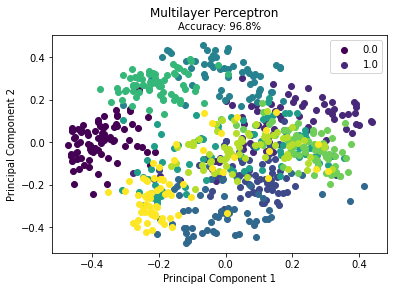

In [ ]:
if __name__ == "__main__":
  main()
  

In [ ]:
def loadMinst():
  f = gzip.open("/content/drive/MyDrive/project/MachineLearning/dataset/mnist.pkl.gz", 'rb')
  train_set, valid_set, test_set = pickle.load(f, encoding = "latin1")
  f.close()

  return [train_set, valid_set, test_set]

#Pytorch : Data in torchvision datasets
This means you have to code an MLP classifier with one layer from scratch. The idea is to classify the MNIST images by their labels. No built-in libraries are allowed to compute backpropagation nor the NLL automatically. Considering the difficulty of the RBFN homework (hw10) and your feedback in the reports, I will upload a guide with a pseudo-code for this homework soon (before tomorrow noon.)

In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

In [ ]:
num_workers = 0
batch_size = 50 # batch size 50
valid_size = 0.2
n_epochs = 50 # epoch 50

In [ ]:
num_workers = 0
batch_size = 50 # batch size 50
valid_size = 0.2
n_epochs = 100 # epoch 100

In [ ]:

transform = transforms.ToTensor()
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'root', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'root', train = False, download = True, transform = transform)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

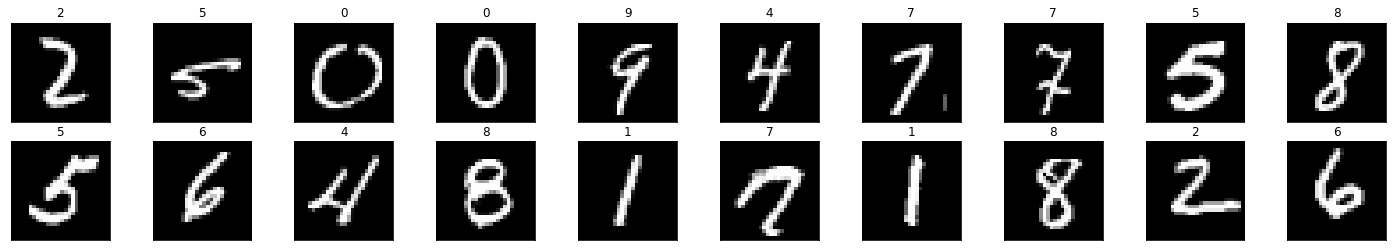

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

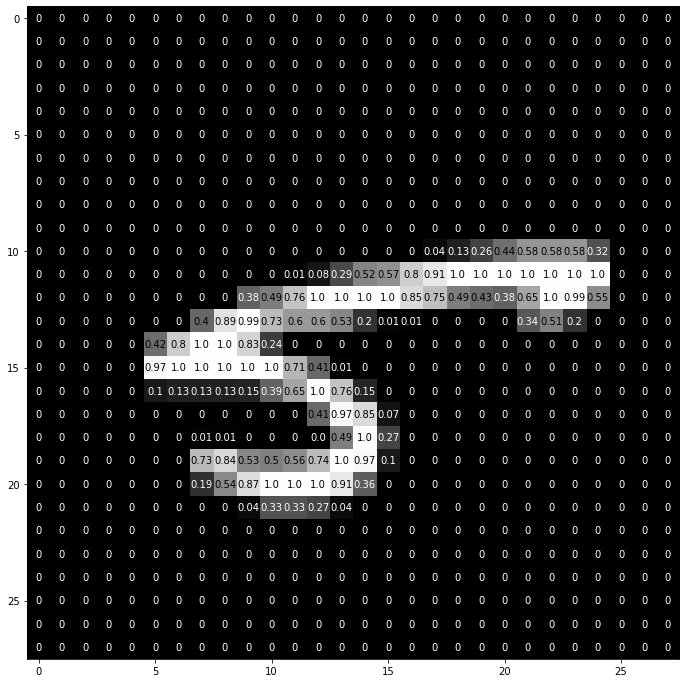

In [ ]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01 ##
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01) 

In [ ]:
num_workers = 0
batch_size = 50 # batch size 50
valid_size = 0.2
n_epochs = 100 # epoch 100

In [ ]:
# This is torchvision data, but compare with from scratch / n_eopchs 50, 100
losses = []
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):

    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      losses.append(train_loss/len(train_loader.sampler))

In [ ]:
   # validate
   model.eval()  # prep model for evaluation
   for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)


In [ ]:
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)


In [ ]:
print(len(train_loader.sampler))

48000


In [ ]:
losses.sort() ## bitch size 50, epoch 100

Text(0.5, 1.0, 'Pytorch torchvision dataset | Batch size 50, epoch 100 Loss')

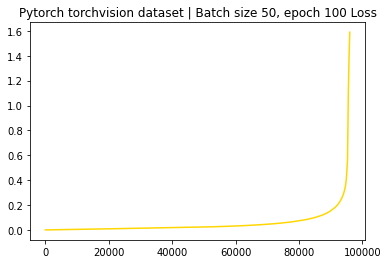

In [ ]:
plt.plot(losses, color = "gold")
plt.title("Pytorch torchvision dataset | Batch size 50, epoch 100 Loss")

In [ ]:
    print("Epoch 100, Batch size 50")
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Epoch 100, Batch size 50
Epoch: 100 	Training Loss: 0.016915 	Validation Loss: 0.000060


In [ ]:
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Validation loss decreased (inf --> 0.000060).  Saving model ...


In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)

In [ ]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061216

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9803/10000)


Text(0.5, 1.0, 'Pytorch torchvision dataset | test loss')

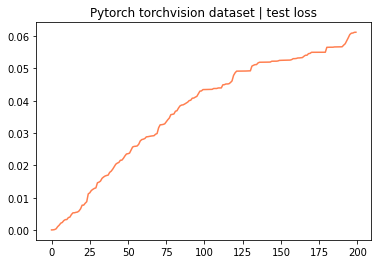

In [ ]:
plt.plot(test_losses, color = "coral")
plt.title("Pytorch torchvision dataset | test loss")

In [ ]:
n_epochs = 200 # epoch 200

In [ ]:
# This is torchvision data, but compare with from scratch / n_eopchs 50, 100
losses = []
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):

    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      losses.append(train_loss/len(train_loader.sampler))

In [ ]:
   # validate
   model.eval()  # prep model for evaluation
   for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)


In [ ]:
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

In [ ]:
losses.sort() ## bitch size 50, epoch 200

Text(0.5, 1.0, 'Pytorch torchvision dataset | Batch size 50, epoch 200 Loss')

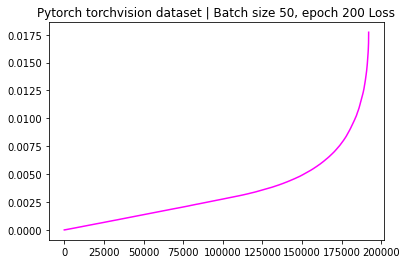

In [ ]:
plt.plot(losses, color = "magenta")
plt.title("Pytorch torchvision dataset | Batch size 50, epoch 200 Loss")

In [ ]:
    print("Batch size 50")
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Batch size 50
Epoch: 200 	Training Loss: 0.003104 	Validation Loss: 0.000069


In [ ]:
    # save model if validation loss has decreased # epoch 200
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Validation loss decreased (inf --> 0.000069).  Saving model ...


In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)

In [ ]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.067691

Test Accuracy of     0: 98% (2910/2940)
Test Accuracy of     1: 99% (3384/3405)
Test Accuracy of     2: 98% (3054/3096)
Test Accuracy of     3: 98% (2973/3030)
Test Accuracy of     4: 98% (2901/2946)
Test Accuracy of     5: 97% (2610/2676)
Test Accuracy of     6: 98% (2826/2874)
Test Accuracy of     7: 97% (3015/3084)
Test Accuracy of     8: 97% (2850/2922)
Test Accuracy of     9: 97% (2958/3027)

Test Accuracy (Overall): 98% (29481/30000)


Text(0.5, 1.0, 'Pytorch torchvision dataset | test loss')

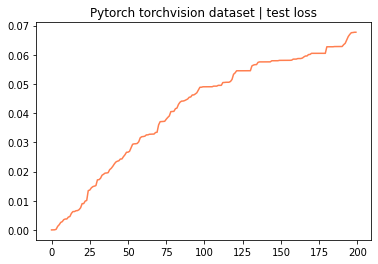

In [ ]:
plt.plot(test_losses, color = "coral")
plt.title("Pytorch torchvision dataset | test loss") # epoch 200, batch size 50

In [ ]:

n_epochs = 500 # epoch 500

In [ ]:
# This is torchvision data, but compare with from scratch / n_eopchs 500
losses = []
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):

    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      losses.append(train_loss/len(train_loader.sampler))

In [ ]:
   # validate
   model.eval()  # prep model for evaluation
   for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

In [ ]:
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

In [ ]:
losses.sort() ## bitch size 50, epoch 500

In [ ]:
plt.plot(losses, color = "deeppink")
plt.title("Pytorch torchvision dataset | Batch size 50, epoch 500 Loss")

In [ ]:
    print("Batch size 50")
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

In [ ]:
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [ ]:
model.load_state_dict(torch.load('model.pt'))

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

In [ ]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
plt.plot(test_losses, color = "coral")
plt.title("Pytorch torchvision dataset | test loss") # epoch 500, batch size 50

Text(0.5, 1.0, 'Pytorch torchvision dataset | Batch size 50, epoch 50 Loss')

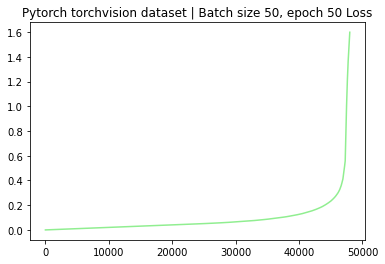

In [ ]:
plt.plot(losses, color = "lightgreen")
plt.title("Pytorch torchvision dataset | Batch size 50, epoch 50 Loss")

In [ ]:
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Epoch: 50 	Training Loss: 0.048037 	Validation Loss: 0.000000


In [ ]:
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Validation loss decreased (inf --> 0.000000).  Saving model ...


In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)

In [ ]:
print(len(test_loader.sampler))

10000


In [ ]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.068261

Test Accuracy of     0: 98% (1938/1960)
Test Accuracy of     1: 99% (2250/2270)
Test Accuracy of     2: 97% (2022/2064)
Test Accuracy of     3: 97% (1976/2020)
Test Accuracy of     4: 97% (1922/1964)
Test Accuracy of     5: 96% (1730/1784)
Test Accuracy of     6: 97% (1872/1916)
Test Accuracy of     7: 97% (2000/2056)
Test Accuracy of     8: 97% (1892/1948)
Test Accuracy of     9: 96% (1954/2018)

Test Accuracy (Overall): 97% (19556/20000)


Text(0.5, 1.0, 'Pytorch torchvision dataset | test loss')

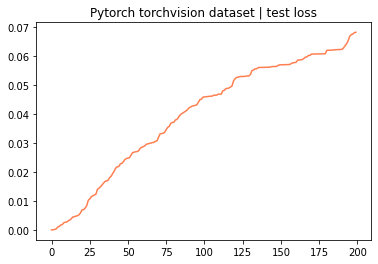

In [ ]:
plt.plot(test_losses, color = "coral")
plt.title("Pytorch torchvision dataset | test loss") # epoch 50, batch size 50

# pytorch : datasets 

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import pyplot as plt
from matplotlib import cm

import pandas as pd

%matplotlib inline


In [ ]:
test_x.shape

torch.Size([10000, 784])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
train_X = torch.from_numpy(train_x).float().to(device)
train_Y = torch.from_numpy(train_y).long().to(device)


test_X = torch.from_numpy(test_x).float().to(device)
test_Y = torch.from_numpy(test_y).long().to(device)

print(train_X.shape)
print(train_Y.shape)

TypeError: ignored

In [ ]:
train = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train, batch_size=50, shuffle=True) # batch size 50

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 10)
    
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.dropout(x, training=self.training)
    x = self.fc6(x)
    return F.log_softmax(x)
    
model = Net()
#model.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
losses = []
for epoch in range(50): # epoch 50
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
#
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

50 0.11184122637342142


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)

In [ ]:
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print("[epoch 50, batch size 50]")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

[epoch 50, batch size 50]
===Pytorch Multi-Layer Perceptron accuracy===
0.9688


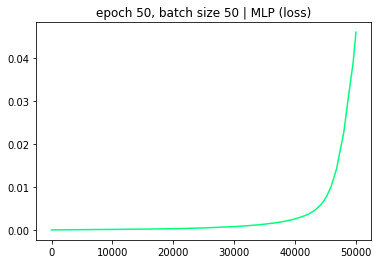

In [ ]:
losses.sort()
#plot
import matplotlib.pyplot as plt

plt.plot(losses, color = "springgreen")
plt.title("epoch 50, batch size 50 | MLP (loss)")
plt.show()

In [ ]:
losses = []
for epoch in range(100): # epoch 100
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# 100
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

100 0.9046400394459511


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)

In [ ]:
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print("[epoch 100, batch size 50]")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

[epoch 100, batch size 50]
===Pytorch Multi-Layer Perceptron accuracy===
0.9705


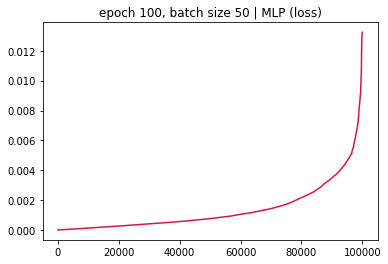

In [ ]:
losses.sort()
#plot
import matplotlib.pyplot as plt

plt.plot(losses, color = "crimson")
plt.title("epoch 100, batch size 50 | MLP (loss)")
plt.show()

In [ ]:
losses = []
for epoch in range(200): # epoch 200
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
#
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

200 0.15457106168458523


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)

In [ ]:
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print("[epoch 200, batch size 50]")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

[epoch 200, batch size 50]
===Pytorch Multi-Layer Perceptron accuracy===
0.9741


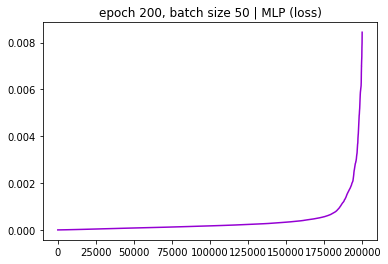

In [ ]:
losses.sort()
#plot
import matplotlib.pyplot as plt

plt.plot(losses, color = "darkviolet")
plt.title("epoch 200, batch size 50 | MLP (loss)")
plt.show()

In [ ]:
losses = []
for epoch in range(500): # epoch 500 
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# 500
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

500 0.0675425435661996


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)

In [ ]:
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print("[epoch 500, batch 50]")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

[epoch 500, batch 50]
===Pytorch Multi-Layer Perceptron accuracy===
0.9731


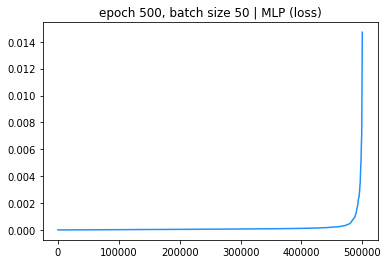

In [ ]:
losses.sort()
#plot
import matplotlib.pyplot as plt

plt.plot(losses, color = "dodgerblue")
plt.title("epoch 500, batch size 50 | MLP (loss)")
plt.show()

In [ ]:
# I think Machine Learning library /beset epoch 100 or 200
# so, batch size 10 from 50

In [ ]:
train = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train, batch_size=10, shuffle=True) #batch size 10

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 10)
    
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.dropout(x, training=self.training)
    x = self.fc6(x)
    return F.log_softmax(x)
    
model = Net()
model.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
losses = []
for epoch in range(50): # epoch 50, batch size 10 /
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

50 11523.667226552963


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())
print("[batch size 10, epoch 50]")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

[batch size 10, epoch 50]
===Pytorch Multi-Layer Perceptron accuracy===
0.0985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


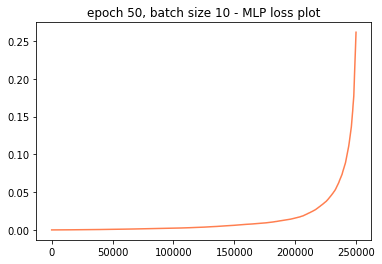

In [ ]:
losses.sort()
#plot
import matplotlib.pyplot as plt

plt.plot(losses, color = "coral")
plt.title("epoch 50, batch size 10 - MLP loss plot")
plt.show()

In [ ]:
losses = []
for epoch in range(100): # epoch 100, batch size 10
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

100 0.24859439331033428


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())
print("[batch size 10, epoch 100]")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

batch size 10, epoch 100
===Pytorch Multi-Layer Perceptron accuracy===
0.9813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


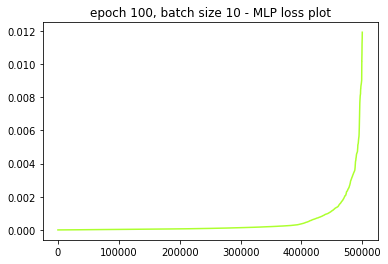

In [ ]:
losses.sort()
#plot 
import matplotlib.pyplot as plt

plt.plot(losses, color = "greenyellow")
plt.title("epoch 100, batch size 10 - MLP loss plot")
plt.show()

In [ ]:
# loss list
losses = []
for epoch in range(200): # epoch 200, batch size 10
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
                     
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss/len(train_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

200 0.3698943561307555


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())
print("batch size 10, epoch 200")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

batch size 10, epoch 200
===Pytorch Multi-Layer Perceptron accuracy===
0.9793


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


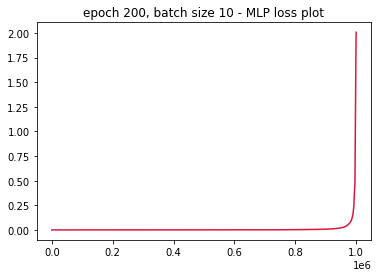

In [ ]:
losses.sort() # sorting plot making 
import matplotlib.pyplot as plt

plt.plot(losses, color = "crimson")
plt.title("epoch 200, batch size 10 - MLP loss plot")
plt.show()

In [ ]:
# loss list appen
losses = []
for epoch in range(500): # epoch 500, batch size 10
  total_loss = 0 #batch loss 
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

500 0.05112351864296549


In [ ]:
test_x, test_y = Variable(test_X), Variable(test_Y)
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())
print("batch size 10, epoch 500")
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

batch size 10, epoch 500
===Pytorch Multi-Layer Perceptron accuracy===
0.9814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


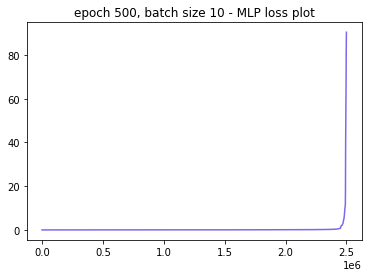

In [ ]:
losses.sort() # sorting plot making 
import matplotlib.pyplot as plt

plt.plot(losses, color = "mediumslateblue")
plt.title("epoch 500, batch size 10 - MLP loss plot")
plt.show()